# Trial flow fields

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase, broader_label

one = ONE(base_url='https://alyx.internationalbrainlab.org')

## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Load data

List design matrices' eids

In [3]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

In [4]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)
epoch_df = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}
    epoch_df[mouse_name] = {}
    
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
                
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        training_set = np.array(design_matrix[var_names]).copy() 

        # Get trial epoch
        bins_df = bins_per_trial_phase(design_matrix, session_trials)
        bins_df = bins_df.rename(columns={0: 'Bin'})
        new_df = design_matrix.merge(bins_df, on='Bin')
        new_df = broader_label(new_df)
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer().fit(standardized)
            normalized = normalizer.transform(standardized)
            
            matrix_all[mouse_name][session] = normalized
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            epoch_df[mouse_name][session] = new_df
            
        else:
            print(session)
    else:
        print(mat)

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

poch_DY_013.png_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

portances.svg_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

lls_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

poch_CSHL060.png_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

_matrix_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

1b61b7f2-a599-4e40-abd6-3e758d2c9e25
_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

## Concatenate sessions of the same animal

In [5]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

### Custom functions

## Loop through animals

In [10]:
iters = 100
label = 'broader_label'

cross_stats = pd.DataFrame(columns=['var', 'epoch', 'hue', 'difference', 'p_value', 'idx'])
for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
        
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Mouse ' + mouse_name)

        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        epoch_matrix = epoch_df[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            # epoch =  epoch_df[mouse_name][session] = new_df

        # # Compute results for this session
        # try:
        #     summary_stats = compute_p_value(epoch_matrix, var_names, iters, label)
        #     summary_stats['idx'] = mat
        # except:
        #     print(mat)
                        
        # # Save overall results
        # if m == 0:
        #     cross_stats = summary_stats
        # else:
        #     cross_stats = cross_stats.append(summary_stats)


Mouse SWC_052


In [47]:
def pca_behavior(epoch_matrix, keep_pc):
    
    """
    PRINCIPLE COMPONENT ANALYSES
    """
    use_mat = epoch_matrix[var_names]
    X = np.array(use_mat) # (n_samples, n_features)
    #X = np.array(design_matrix)

    # Mean centered and equal variance (redundant code)
    # scaler = StandardScaler()
    # scaler.fit(X)
    
    scaler = StandardScaler()
    standardized = scaler.fit_transform(X)
    # Normalize between 0 and 1
    normalizer = Normalizer().fit(standardized)
    X_normalized = normalizer.transform(standardized)
    
    pca = PCA() # svd_solver='full'
    #pca.fit(scaler.transform(X))
    # X_reduced = pca.fit_transform(scaler.transform(X))
    X_reduced = pca.fit_transform(X_normalized)

    # Plot variance explained per principle component
    fig, ax = plt.subplots(figsize=[6,5])
    plt.rc('font', size=18)
    keep_pc = np.shape(X)[1]
    plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
    plt.xticks(np.arange(1, keep_pc, 1))
    plt.xlabel('PCs')
    plt.ylabel('% Variance explained')
    plt.show()
    
    return X_reduced, X


def augment_data(X_reduced, keep_pc):
    
    if np.shape(X_reduced)[0] == np.shape(epoch_matrix)[0]:
        # Plot projections of datapoints into first 3 principal components
        augmented_data = pd.DataFrame(columns=['Bin'], index=range(np.shape(X_reduced)[0]))
        augmented_data['Bin'] = epoch_matrix['Bin']
        augmented_data['label'] = epoch_matrix['label']
        augmented_data['Trial'] = epoch_matrix['Trial']
        augmented_data['feedback'] = epoch_matrix['feedback']
        augmented_data['signed_contrast'] = epoch_matrix['signed_contrast']
        augmented_data['choice'] = epoch_matrix['choice']
        augmented_data['broader_label'] = epoch_matrix['broader_label']
        
        for p in range(keep_pc):
            augmented_data[str('pc' + str(p+1))] = X_reduced[:, p].transpose()
    else:
        print('Size does not match')

    return augmented_data


def plot_timeseries_pcs(X, augmented_data, var_names, init, range):
    # scaler = StandardScaler()
    # new_X = scaler.fit_transform(X)
    
    scaler = StandardScaler()
    standardized = scaler.fit_transform(X)
    # Normalize between 0 and 1
    normalizer = Normalizer().fit(standardized)
    new_X = normalizer.transform(standardized)

    for v , var in enumerate(var_names):
        plt.plot(new_X[init:init+range, v], color='black', label='Data')
        plt.plot(augmented_data['pc1'], color='red', label='PC 1', alpha=0.5)
        plt.plot(augmented_data['pc2'], color='green', label='PC 2', alpha=0.5)
        plt.plot(augmented_data['pc3'], color='blue', label='PC 3', alpha=0.5)
        plt.legend()
        plt.title(var)

        plt.xlim([init, init+range])
        plt.show()


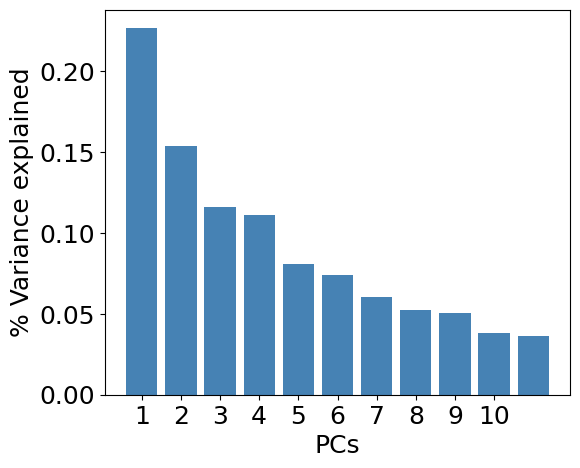

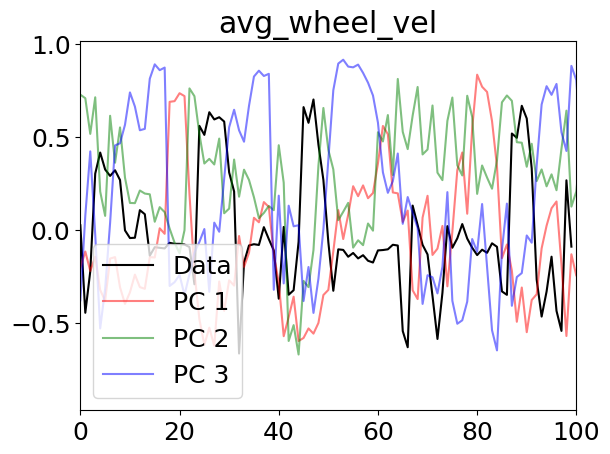

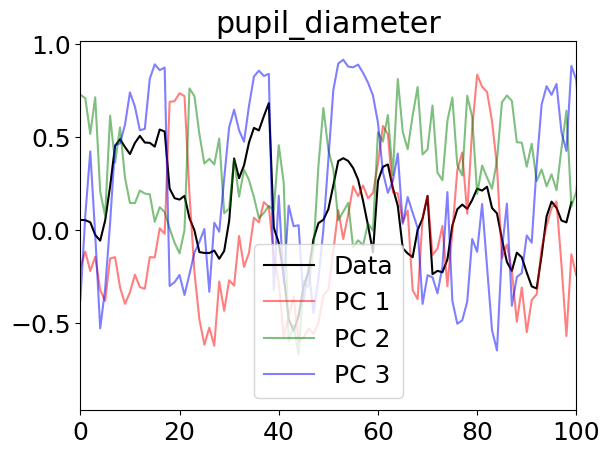

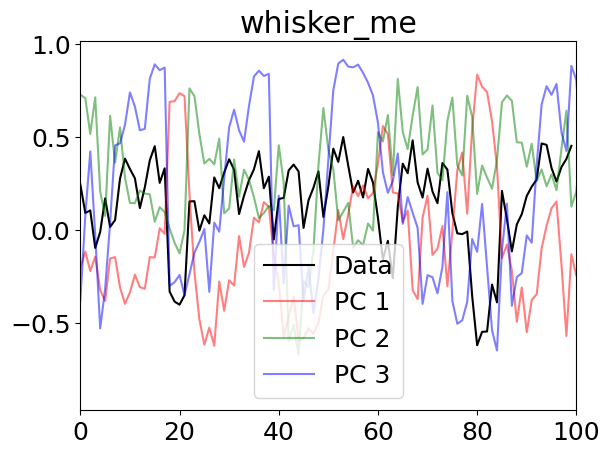

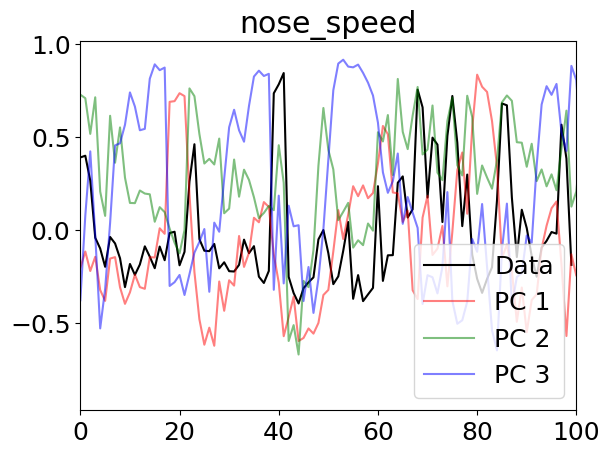

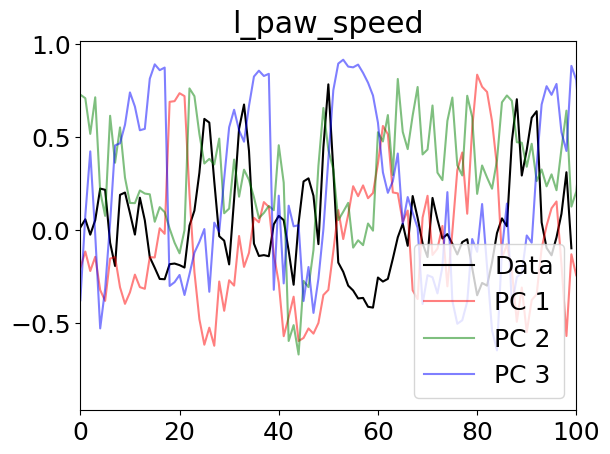

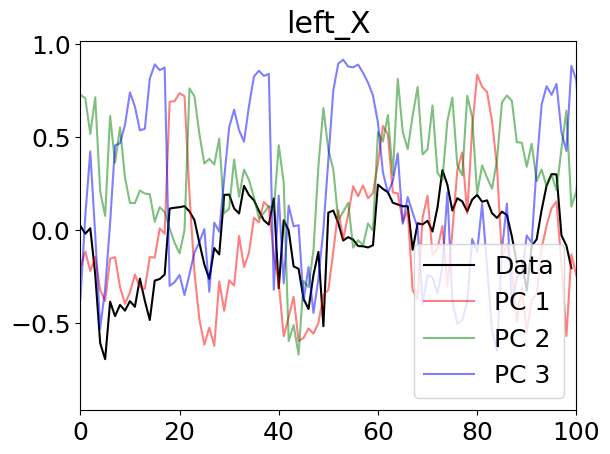

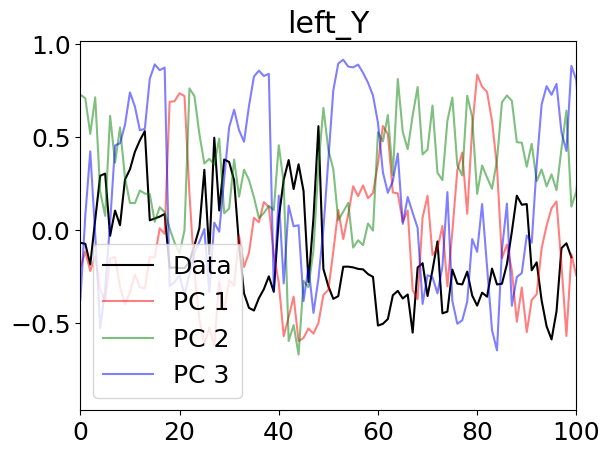

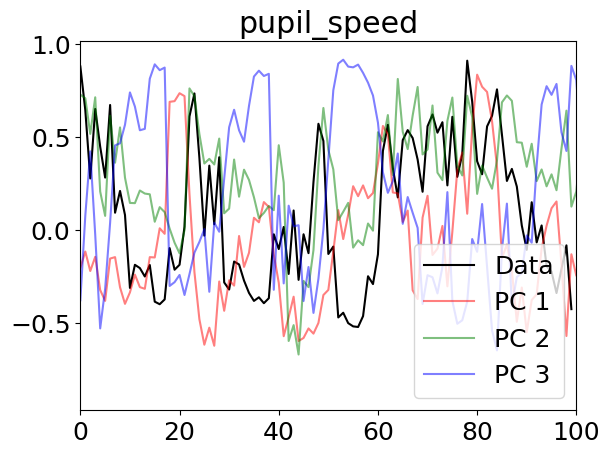

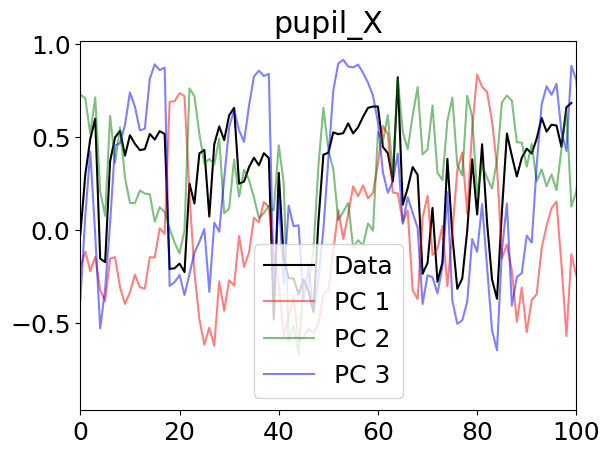

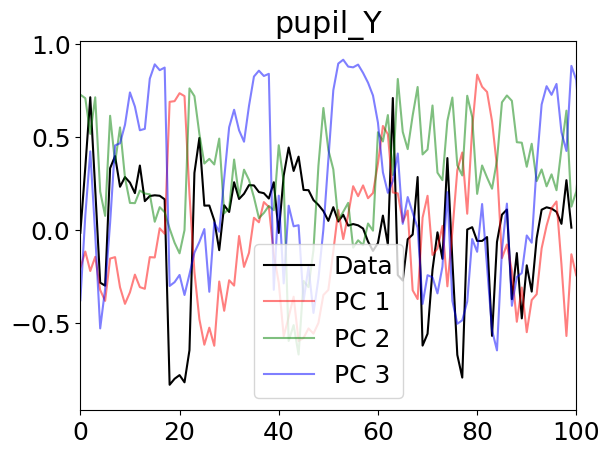

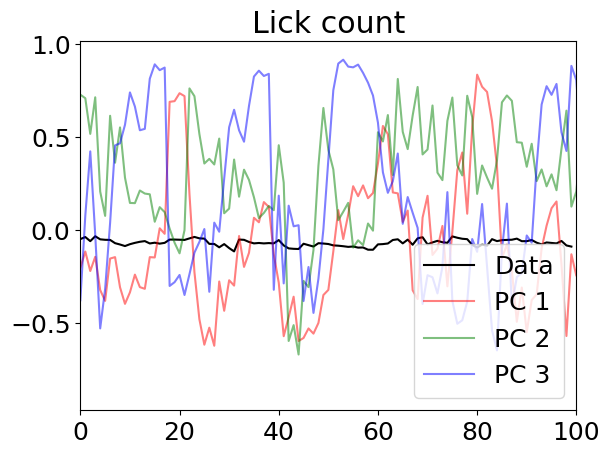

In [48]:
keep_pc = len(var_names)
label = 'broader_label'
# label = 'label'

X_reduced, X = pca_behavior(epoch_matrix, keep_pc)
augmented_data = augment_data(X_reduced, keep_pc)
plot_timeseries_pcs(X, augmented_data, var_names, 0, 100)

In [74]:
def group_per_phase(data, label = 'broader_label'):

    """ Get trial classes """
    # Mean per label
    mean_label = pd.DataFrame(data.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
    mean_label = mean_label.reset_index(level=[0,1])

    # Get correct and incorrect, left and right trials
    trials_correct = mean_label.loc[mean_label['label']=='Correct feedback', 'Trial']
    trials_incorrect = mean_label.loc[mean_label['label']=='Incorrect feedback', 'Trial']
    trials_left = mean_label.loc[mean_label['label']=='Left choice', 'Trial']
    trials_right = mean_label.loc[mean_label['label']=='Right choice', 'Trial']

    correct_left = np.intersect1d(trials_correct, trials_left)
    correct_right = np.intersect1d(trials_correct, trials_right)
    incorrect_left = np.intersect1d(trials_incorrect, trials_left)
    incorrect_right = np.intersect1d(trials_incorrect, trials_right)

    correct_left_data = data.loc[data['Trial'].isin(correct_left)]
    incorrect_left_data = data.loc[data['Trial'].isin(incorrect_left)]
    correct_right_data = data.loc[data['Trial'].isin(correct_right)]
    incorrect_right_data = data.loc[data['Trial'].isin(incorrect_right)]

    """ Mean per label per trial """
    mean_trial = pd.DataFrame(data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    mean_trial = mean_trial.reset_index(level=[0, 1])

    # Mean per label
    correct_left_data_mean = pd.DataFrame(correct_left_data.groupby([label])['pc1', 'pc2'].mean())
    correct_left_data_mean = correct_left_data_mean.reset_index(level=[0])
    incorrect_left_data_mean = pd.DataFrame(incorrect_left_data.groupby([label])['pc1', 'pc2'].mean())
    incorrect_left_data_mean = incorrect_left_data_mean.reset_index(level=[0])
    correct_right_data_mean = pd.DataFrame(correct_right_data.groupby([label])['pc1', 'pc2'].mean())
    correct_right_data_mean = correct_right_data_mean.reset_index(level=[0])
    incorrect_right_data_mean = pd.DataFrame(incorrect_right_data.groupby([label])['pc1', 'pc2'].mean())
    incorrect_right_data_mean = incorrect_right_data_mean.reset_index(level=[0])

    # Mean per label per trial
    correct_left_data = pd.DataFrame(correct_left_data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    correct_left_data = correct_left_data.reset_index(level=[0, 1])
    incorrect_left_data = pd.DataFrame(incorrect_left_data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    incorrect_left_data = incorrect_left_data.reset_index(level=[0, 1])
    correct_right_data = pd.DataFrame(correct_right_data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    correct_right_data = correct_right_data.reset_index(level=[0, 1])
    incorrect_right_data = pd.DataFrame(incorrect_right_data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
    incorrect_right_data = incorrect_right_data.reset_index(level=[0, 1])

    if label == 'broader_label':
        sort_dict = {'Quiescence':0, 'Stimulus': 1, 'Choice':2,'ITI':3}
    elif label=='label':
        sort_dict = {'Quiescence':0,'Stimulus left':1, 'Stimulus right': 2, 
                     'Left choice': 3, 'Right choice': 4, 'Correct feedback': 5,
                     'Incorrect feedback': 6, 'ITI_correct': 7, 'ITI_incorrect': 8,
                     }
    correct_left_data_mean = correct_left_data_mean.iloc[correct_left_data_mean[label].map(sort_dict).sort_values().index]
    correct_right_data_mean = correct_right_data_mean.iloc[correct_right_data_mean[label].map(sort_dict).sort_values().index]
    incorrect_left_data_mean = incorrect_left_data_mean.iloc[incorrect_left_data_mean[label].map(sort_dict).sort_values().index]
    incorrect_right_data_mean = incorrect_right_data_mean.iloc[incorrect_right_data_mean[label].map(sort_dict).sort_values().index]

    grouped = [correct_left_data, incorrect_left_data, correct_right_data, incorrect_right_data]
    grouped_mean = [correct_left_data_mean, incorrect_left_data_mean, correct_right_data_mean, incorrect_right_data_mean]

    return grouped, grouped_mean


def plot_trial_epoch(augmented_data, label):
    
    trials = augmented_data['Trial'].unique()

    fig, axs = plt.subplots(nrows=2 , ncols=2, sharex=True, sharey=True, figsize=[12, 10])

    for t, trial in enumerate(trials):

        use_data = augmented_data.loc[augmented_data['Trial']==trial]
        # trial_data_pc1 = augmented_data.loc[augmented_data['Trial']==trial, 'pc1']
        # trial_data_pc2 = augmented_data.loc[augmented_data['Trial']==trial, 'pc2']
        
        if ('Correct feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
            sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0, 0]) # s=200
            #axs[0, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
        elif ('Correct feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
            sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0, 1]) # s=200
            #axs[0, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
        elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
            sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1, 0]) # s=200
            #axs[1, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
        elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
            sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1, 1]) # s=200
            #axs[1, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
        

        axs[0, 0].set_title('Correct choice left')
        axs[0, 1].set_title('Correct choice right')
        axs[1, 0].set_title('Incorrect choice left')
        axs[1, 1].set_title('Incorrect choice right')

    grouped, grouped_mean = group_per_phase(augmented_data, label)

    correct_left_data = grouped[0]
    incorrect_left_data = grouped[1]
    correct_right_data = grouped[2]
    incorrect_right_data = grouped[3]

    correct_left_data_mean = grouped_mean[0]
    incorrect_left_data_mean = grouped_mean[1]
    correct_right_data_mean = grouped_mean[2]
    incorrect_right_data_mean = grouped_mean[3]

    axs[0, 0].plot(np.array(correct_left_data_mean['pc1']), np.array(correct_left_data_mean['pc2']), color='Black') 
    axs[0, 1].plot(np.array(correct_right_data_mean['pc1']), np.array(correct_right_data_mean['pc2']), color='Black') 
    axs[1, 0].plot(np.array(incorrect_left_data_mean['pc1']), np.array(incorrect_left_data_mean['pc2']), color='Black') 
    axs[1, 1].plot(np.array(incorrect_right_data_mean['pc1']), np.array(incorrect_right_data_mean['pc2']), color='Black') 

    sns.scatterplot(x='pc1', y='pc2', data=correct_left_data_mean, alpha=1, hue=label, legend=None, palette='viridis', ax=axs[0, 0], s=200)
    sns.scatterplot(x='pc1', y='pc2', data=correct_right_data_mean, alpha=1, hue=label, palette='viridis', ax=axs[0, 1], s=200)
    axs[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 0.65))
    sns.scatterplot(x='pc1', y='pc2', data=incorrect_left_data_mean, alpha=1, hue=label, legend=None, palette='viridis', ax=axs[1, 0], s=200)
    sns.scatterplot(x='pc1', y='pc2', data=incorrect_right_data_mean, alpha=1, hue=label, legend=None, palette='viridis', ax=axs[1, 1], s=200)

    # Create grid
    axs[0, 0].vlines(0, -3, 4, color='Gray', linestyles='--')
    axs[0, 0].hlines(0, -3, 4, color='Gray', linestyles='--')
    axs[0, 1].vlines(0, -3, 4, color='Gray', linestyles='--')
    axs[0, 1].hlines(0, -3, 4, color='Gray', linestyles='--')
    axs[1, 0].vlines(0, -3, 4, color='Gray', linestyles='--')
    axs[1, 0].hlines(0, -3, 4, color='Gray', linestyles='--')
    axs[1, 1].vlines(0, -3, 4, color='Gray', linestyles='--')
    axs[1, 1].hlines(0, -3, 4, color='Gray', linestyles='--')

    axs[0, 0].set_xlim(np.min(correct_left_data['pc1'])-.3, np.max(correct_left_data['pc1'])+.3)
    axs[0, 0].set_ylim(np.min(correct_left_data['pc2'])-.3, np.max(correct_left_data['pc2'])+.3)


    plt.tight_layout()
    plt.show()


In [230]:
a = np.array([2424])

In [234]:
2424 not in target_data

False

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_51787/1401864155.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append(temp_grid)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_51787/1401864155.py:59: FutureWarning: The 

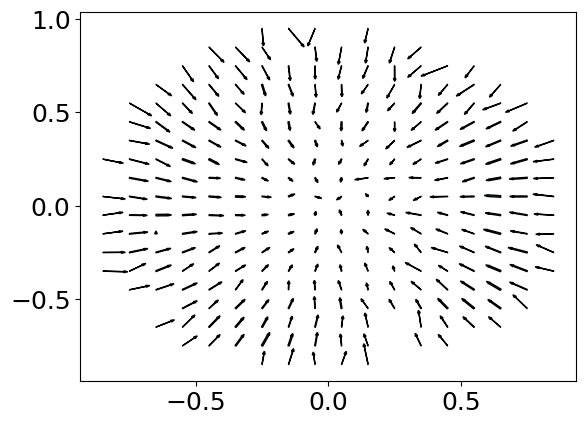

In [238]:
# Define the range and interval for grid
start, end, step = -1, 1, 0.1
# Create arrays for x and y coordinates
x_axis = np.arange(start, end + step, step)
y_axis = np.arange(start, end + step, step)

grid = pd.DataFrame(columns=['x_grid', 'x_vec', 'y_grid', 'y_vec', 'samples', 'magnitude'])

# Loop through values of grid
for x, x_value in enumerate(x_axis):
    for y, y_value in enumerate(y_axis):
        
        temp_grid = pd.DataFrame(columns=['x_grid', 'x_vec', 'y_grid', 'y_vec', 'samples', 'magnitude'], index=range(1))
        # Coordinates for zeroing
        bin_zero_x = x_value + step/2
        bin_zero_y = y_value + step/2
        
        # Get values from bin
        bin_x_all = augmented_data.loc[(augmented_data['pc1']>x_value) & (augmented_data['pc1']< x_value+step), 'pc1']
        bin_y_all = augmented_data.loc[(augmented_data['pc2']>y_value) & (augmented_data['pc2']< y_value+step), 'pc2']
        bin_data = np.intersect1d(bin_x_all.index, bin_y_all.index)
        
        bin_x = augmented_data['pc1'][bin_data]
        bin_y = augmented_data['pc2'][bin_data]
          
        # Get targets
        target_data = bin_data + 1   
        if len(augmented_data) in target_data:
            # Save
            temp_grid['x_grid'] = x_value
            temp_grid['y_grid'] = y_value
            temp_grid['x_vec'] = 0
            temp_grid['y_vec'] = 0
            temp_grid['samples'] = 0
            temp_grid['magnitude'] = 0
            
            grid = grid.append(temp_grid)
        else:
            target_x = augmented_data['pc1'][target_data]
            target_y = augmented_data['pc2'][target_data]
            
            # Compute vectors
            vec_x = np.array(target_x) - np.array(bin_x) - bin_zero_x
            vec_y = np.array(target_y) - np.array(bin_y) - bin_zero_y
            
            # Sum vectors and normalize
            summed_x = np.mean(vec_x)
            summed_y = np.mean(vec_y)
            length = np.sqrt(summed_x**2 + summed_y**2)
            
            # Save
            temp_grid['x_grid'] = x_value
            temp_grid['y_grid'] = y_value
            temp_grid['x_vec'] = summed_x
            temp_grid['y_vec'] = summed_y
            temp_grid['samples'] = len(vec_x)
            temp_grid['magnitude'] = length
            
            grid = grid.append(temp_grid)

max_magnitude = np.max(grid['magnitude'])

grid['x_norm'] = grid['x_vec']*step/max_magnitude 
grid['y_norm'] = grid['y_vec']*step/max_magnitude 
# grid.loc[np.isnan(grid['samples'])]
# Loop through values of grid
for x, x_value in enumerate(x_axis):
    for y, y_value in enumerate(y_axis):
        # Coordinates for zeroing
        bin_zero_x = x_value + step/2
        bin_zero_y = y_value + step/2
        dx = list(grid.loc[(grid['x_grid']==x_value) & (grid['y_grid']==y_value),'x_norm'])[0]
        dy = list(grid.loc[(grid['x_grid']==x_value) & (grid['y_grid']==y_value),'y_norm'])[0]
        sample_size = list(grid.loc[(grid['x_grid']==x_value) & (grid['y_grid']==y_value),'samples'])[0]
        # plt.plot([bin_zero_x, grid['x_norm'][x*y]+bin_zero_x], [bin_zero_y, grid['y_norm'][x*y]+bin_zero_y], color='blue')
        # plt.plot([bin_zero_x, dx+bin_zero_x], [bin_zero_y, dy+bin_zero_y], color='blue')
        plt.arrow(bin_zero_x, bin_zero_y, dx, dy, head_width=.01, width=0.0003*sample_size)  # grid['samples'][(x+1)*(y*1)]
# plt.xlim([-.5, .5])
# plt.ylim([-.5, .5])
# for i in range(len(vec_x)):
#     plt.plot([0, vec_x[i]*step/max_magnitude], [0, vec_y[i]*step/max_magnitude], color='black', alpha=0.5)
# plt.plot([0, summed_x*step/max_magnitude], [0, summed_y*step/max_magnitude], color='blue')
        
        
        
# find all values that fall inside a given bin
# Calculate vector (x and y coordinates) and zero on center of bin 

/tmp/ipykernel_51787/1503206003.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(data.groupby(['label', 'Trial'])['pc1', 'pc2'].mean())
/tmp/ipykernel_51787/1503206003.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_trial = pd.DataFrame(data.groupby([label, 'Trial'])['pc1', 'pc2'].mean())
/tmp/ipykernel_51787/1503206003.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correct_left_data_mean = pd.DataFrame(correct_left_data.groupby([label])['pc1', 'pc2'].mean())
/tmp/ipykernel_51787/1503206003.py:31: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  incorrect_left_data_mean = pd.DataFrame(incorrect_left_data.groupby([label])['pc1'

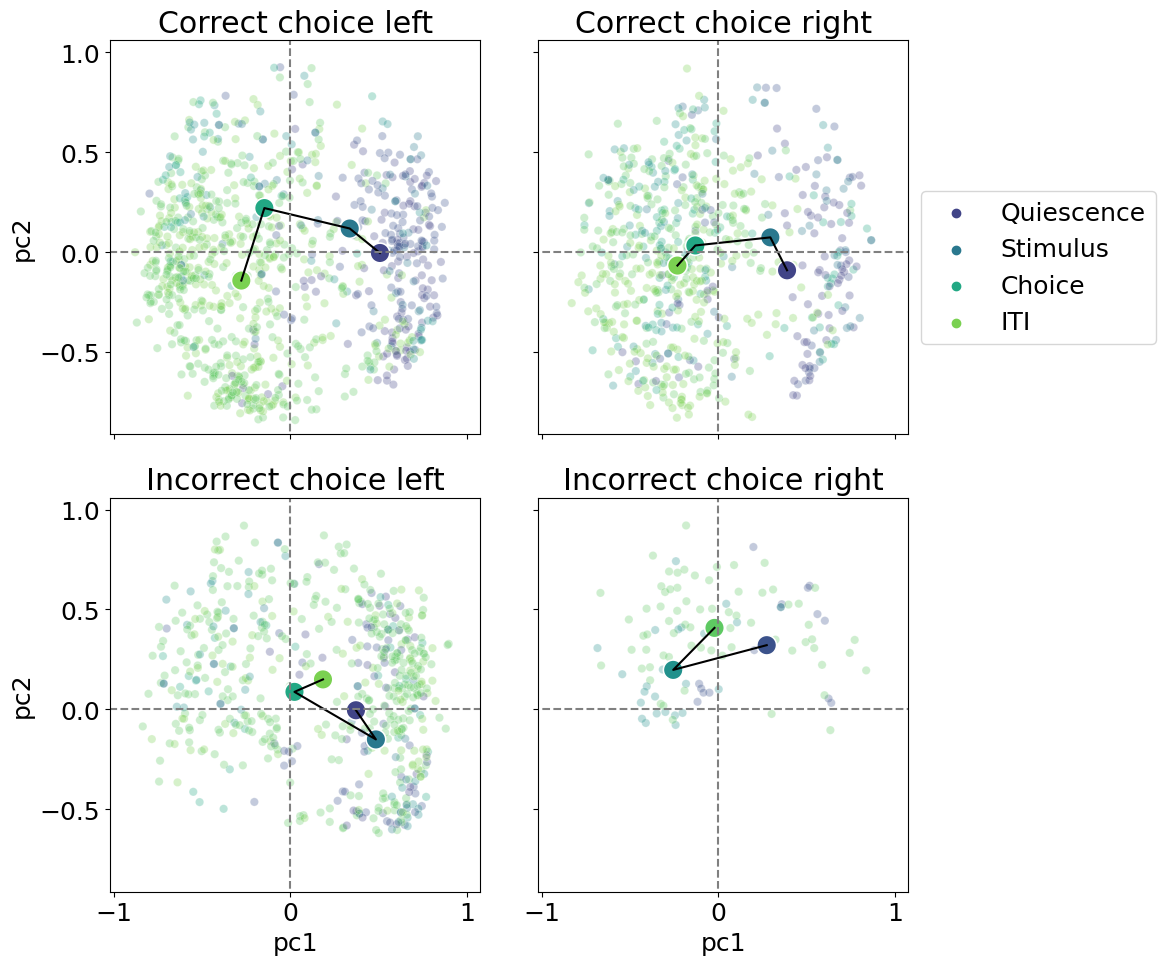

In [76]:
plot_trial_epoch(augmented_data, label)

In [ ]:
trials = augmented['Trial'].unique()
label = 'broader_label'

fig, axs = plt.subplots(nrows=1 , ncols=2, sharex=True, sharey=True, figsize=[10, 5])

for t, trial in enumerate(trials):

    use_data = augmented.loc[augmented['Trial']==trial]
    trial_data_pc1 = augmented.loc[augmented['Trial']==trial, 'pc1']
    trial_data_pc2 = augmented.loc[augmented['Trial']==trial, 'pc2']
    
    if ('Correct feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0]) # s=200
        #axs[0, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Correct feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1]) # s=200
        #axs[0, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Left choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[0]) # s=200
        #axs[1, 0].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    elif ('Incorrect feedback' in np.array(use_data['label'])) & ('Right choice' in np.array(use_data['label'])):
        sns.scatterplot(x='pc1', y='pc2', data=use_data, alpha=0.3, hue=label, palette='viridis', legend=None, ax=axs[1]) # s=200
        #axs[1, 1].plot(trial_data_pc1, trial_data_pc2, color='Gray', alpha=0.1) 
    
    axs[0].set_title('Choice left')
    axs[1].set_title('Choice right')

grouped, grouped_mean = group_per_phase(augmented, label)

correct_left_data = grouped[0]
incorrect_left_data = grouped[1]
correct_right_data = grouped[2]
incorrect_right_data = grouped[3]

correct_left_data_mean = grouped_mean[0]
incorrect_left_data_mean = grouped_mean[1]
correct_right_data_mean = grouped_mean[2]
incorrect_right_data_mean = grouped_mean[3]
    
axs[0].plot(np.array(correct_left_data_mean['pc1']), np.array(correct_left_data_mean['pc2']), color='Black') 
axs[1].plot(np.array(correct_right_data_mean['pc1']), np.array(correct_right_data_mean['pc2']), color='Black') 
axs[0].plot(np.array(incorrect_left_data_mean['pc1']), np.array(incorrect_left_data_mean['pc2']), color='Black') 
axs[1].plot(np.array(incorrect_right_data_mean['pc1']), np.array(incorrect_right_data_mean['pc2']), color='Black') 

sns.scatterplot(x='pc1', y='pc2', data=correct_left_data_mean, alpha=1, hue=label, legend=None, palette='viridis', ax=axs[0], s=200)
sns.scatterplot(x='pc1', y='pc2', data=correct_right_data_mean, alpha=1, hue=label, palette='viridis', ax=axs[1], s=200)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 0.65))
sns.scatterplot(x='pc1', y='pc2', data=incorrect_left_data_mean, alpha=1, hue=label, legend=None, 
                edgecolor='r', palette='viridis', ax=axs[0], s=200)
sns.scatterplot(x='pc1', y='pc2', data=incorrect_right_data_mean, alpha=1, hue=label, legend=None, 
                edgecolor='r', palette='viridis', ax=axs[1], s=200)

# Create grid
axs[0].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[0].hlines(0, -3, 4, color='Gray', linestyles='--')
axs[1].vlines(0, -3, 4, color='Gray', linestyles='--')
axs[1].hlines(0, -3, 4, color='Gray', linestyles='--')

plt.tight_layout()
plt.show()
